# Predicting Car Prices with PyTorch

Bu projede PyTorch kullanarak araç fiyat tahmini yapan bir makine öğrenimi modeli geliştireceğiz. 
Veri setimiz 258 araç ve 9 özellik içermektedir. Sonuç olarak 'Selling_Price' sütununu tahmin edeceğiz.

### PyTorch
PyTorch, derin öğrenme modelleri geliştirmek için kullanılan açık kaynaklı bir makine öğrenimi kütüphanesidir. Esnekliği ve kullanımı kolay olması, yeni başlayanlar ve deneyimli uygulayıcılar arasında popüler olmasını sağlamaktadır.

[GitHub Linki](https://github.com/FBetulS/car_price_predict/blob/main/README.md)

[Hugging Face - Araç Fiyat Tahmin Uygulaması](https://huggingface.co/spaces/btulftma/car_price_predict)

## Importing Libraries

In [5]:
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from pathlib import Path

## Loading the Data

In [7]:
data_path = Path("car.csv")
raw_df = pd.read_csv(data_path)

In [8]:
raw_df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


| Sütun Adı         | Açıklama                                 |
|-------------------|------------------------------------------|
| **Car_Name**      | Aracın adı                               |
| **Year**          | Aracın üretim yılı                       |
| **Selling_Price** | Aracın satış fiyatı (binlerce birim)   |
| **Present_Price** | Aracın güncel piyasa değeri (binlerce birim) |
| **Kms_Driven**    | Aracın toplam kilometre kullanımı       |
| **Fuel_Type**     | Aracın yakıt tipi (Petrol/Dizel)       |
| **Seller_Type**   | Aracın satıcısı (Bayi/Özel)            |
| **Transmission**  | Vites tipi (Manuel/Automatik)          |
| **Owner**         | Araç sahibi sayısı (0: İlk sahibi)     |

In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [11]:
raw_df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [12]:
raw_df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [17]:
import matplotlib.pyplot as plt

In [19]:
import seaborn as sns

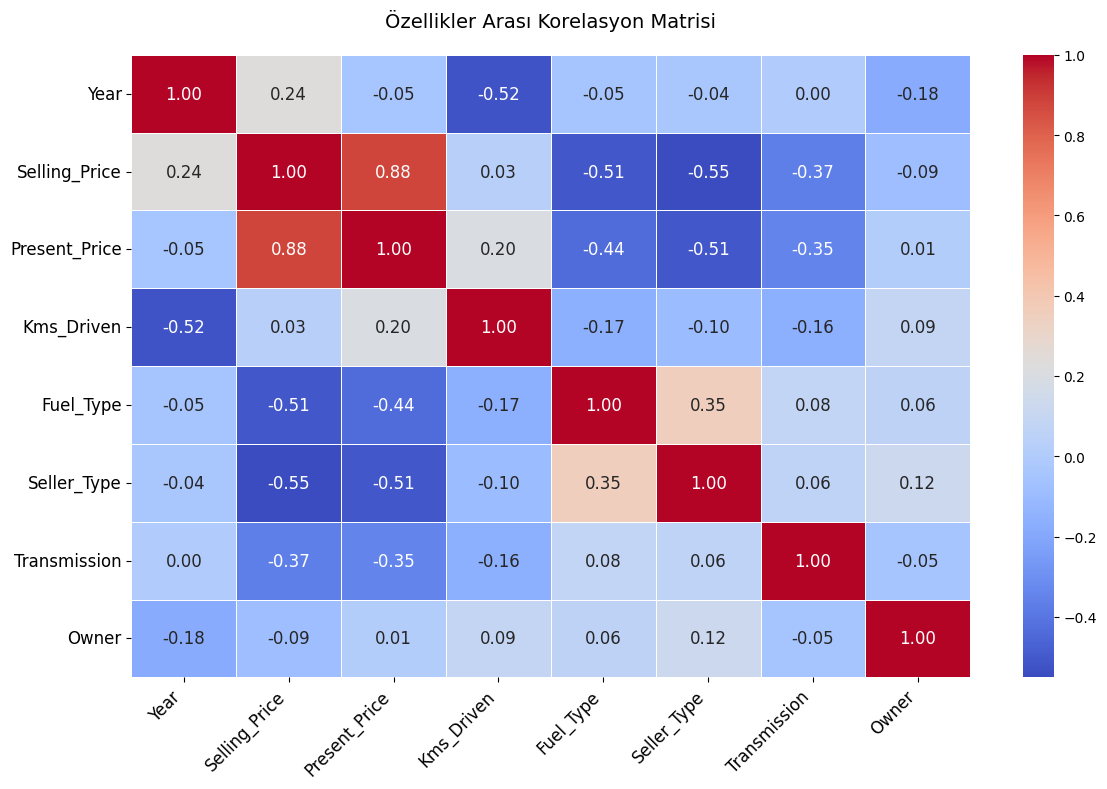

In [21]:
def plot_correlation(df):
    # Kategorik dönüşümler (geçici olarak)
    temp_df = df.copy()
    categorical_cols = ["Fuel_Type", "Seller_Type", "Transmission"]
    for col in categorical_cols:
        temp_df[col] = temp_df[col].astype('category').cat.codes
    
    # Korelasyon matrisi
    plt.figure(figsize=(12,8))
    corr_matrix = temp_df.corr(numeric_only=True)
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap='coolwarm', 
                fmt=".2f", 
                linewidths=.5,
                annot_kws={"size": 12})
    plt.title("Özellikler Arası Korelasyon Matrisi", pad=20, fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

plot_correlation(raw_df)

## Data Preparation

Kategorik verileri sayısallaştırıyoruz ve gereksiz sütunları çıkarıyoruz.
Özellik ölçeklendirme için StandardScaler kullanıyoruz.

In [25]:
def prepare_data(df, test_size=0.15):
    df = df.drop(columns=['Car_Name'], errors='ignore').copy()
    
    # Kategorik dönüşümler
    categorical_cols = ["Fuel_Type", "Seller_Type", "Transmission"]
    for col in categorical_cols:
        df[col] = df[col].astype('category').cat.codes
    
    # Özellik ve hedef ayrımı
    X = df[["Year", "Present_Price", "Kms_Driven", "Owner"] + categorical_cols].values
    y = df["Selling_Price"].values.reshape(-1, 1)
    
    # Ölçeklendirme
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    return scaler_X.fit_transform(X), scaler_y.fit_transform(y), scaler_X, scaler_y

X_scaled, y_scaled, scaler_X, scaler_y = prepare_data(raw_df)

## Creating the Model

### PyTorch Veri Seti Oluşturma
Verileri eğitim ve test setlerine ayırıp PyTorch DataLoader'a dönüştürüyoruz.

In [29]:
def create_datasets(X, y, batch_size=64):
    dataset = TensorDataset(torch.FloatTensor(X), torch.FloatTensor(y))
    
    # Veri bölümleme
    train_size = int(0.85 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    
    return DataLoader(train_ds, batch_size, shuffle=True), DataLoader(val_ds, batch_size*2)

train_loader, val_loader = create_datasets(X_scaled, y_scaled)

### Sinir Ağı Modeli Tasarımı
Daha gelişmiş bir model mimarisi kullanıyoruz.

In [31]:
class CarPricePredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.stack(x)

model = CarPricePredictor(X_scaled.shape[1])
print(model)

CarPricePredictor(
  (stack): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Model Eğitimi ve Optimizasyon
Adam optimizer ve learning rate scheduler kullanıyoruz.

In [35]:
def train_model(model, train_loader, val_loader, epochs=150):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.HuberLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        # Eğitim döngüsü
        model.train()
        batch_losses = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        # Validasyon
        model.eval()
        with torch.no_grad():
            val_loss = sum(loss_fn(model(inputs), targets).item() for inputs, targets in val_loader)/len(val_loader)
        
        # Kayıt tutma
        train_loss = np.mean(batch_losses)
        scheduler.step(val_loss)
        
        # İlerlemeyi kaydet
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # En iyi modeli kaydet
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        # İlerleme raporu
        if (epoch+1) % 15 == 0:
            print(f'Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    
    return history

history = train_model(model, train_loader, val_loader)

Epoch 015 | Train Loss: 0.0332 | Val Loss: 0.0823
Epoch 030 | Train Loss: 0.0192 | Val Loss: 0.0606
Epoch 045 | Train Loss: 0.0156 | Val Loss: 0.0535
Epoch 060 | Train Loss: 0.0181 | Val Loss: 0.0527
Epoch 075 | Train Loss: 0.0135 | Val Loss: 0.0527
Epoch 090 | Train Loss: 0.0175 | Val Loss: 0.0527
Epoch 105 | Train Loss: 0.0163 | Val Loss: 0.0527
Epoch 120 | Train Loss: 0.0161 | Val Loss: 0.0527
Epoch 135 | Train Loss: 0.0153 | Val Loss: 0.0527
Epoch 150 | Train Loss: 0.0143 | Val Loss: 0.0527


### Making Predictions
Eğitim sonuçlarını görselleştirip örnek tahminler yapıyoruz.

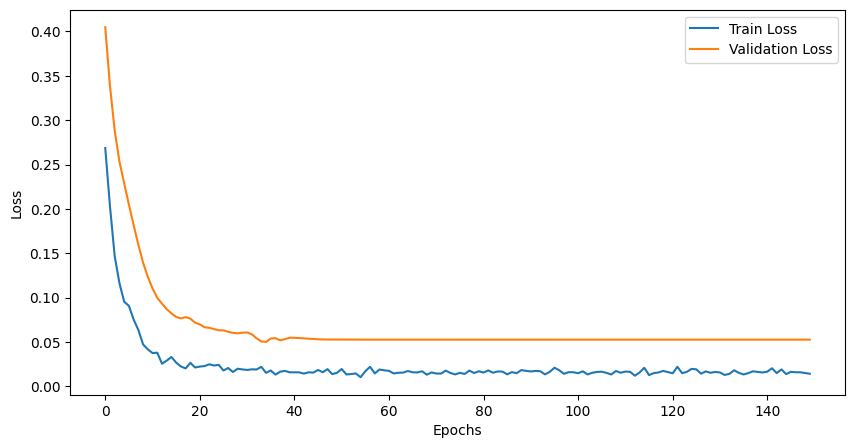

In [37]:
# Kayıp grafiği
plt.figure(figsize=(10,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
def make_prediction(model, scaler_X, scaler_y, sample_data):
    model.eval()
    with torch.no_grad():
        sample_tensor = torch.FloatTensor(scaler_X.transform(sample_data))
        prediction = model(sample_tensor)
        return scaler_y.inverse_transform(prediction.numpy())

test_sample = [[2015, 7.5, 25000, 0, 1, 0, 1]]  # Örnek veri
predicted_price = make_prediction(model, scaler_X, scaler_y, test_sample)
print(f"Tahmini Fiyat: ${predicted_price[0][0]:.2f}")

Tahmini Fiyat: $6.29


In [39]:
torch.save({
    'model_state': model.state_dict(),
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'input_cols': ["Year", "Present_Price", "Kms_Driven", "Owner", "Fuel_Type", "Seller_Type", "Transmission"]
}, 'car_price_model.pth')

## Conclusion
Bu kılavuzda, PyTorch kullanarak araç fiyatlarını tahmin etmek için bir lineer regresyon modeli geliştirdik. Modelin performansını değerlendirdik ve eğitim sürecini görselleştirdik.